In [1]:
# How changing the dataset sample size effects the calibration methods
# Fix training dataset size and change the calib set samples - best method is one that gets max calib with least data

In [2]:
# imports
import sys
import pandas as pd
import numpy as np
sys.path.append('../../') # to access the files in higher directories
sys.path.append('../') # to access the files in higher directories
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import Data.data_provider as dp
import core as cal
from estimators.IR_RF_estimator import IR_RF

In [3]:
# params
calib_methods = ["RF", "Platt" , "ISO", "Rank", "CRF", "VA", "Beta", "Elkan", "tlr"]
metrics = ["acc", "auc", "brier", "ece", "logloss"]
data_list = ["spambase", "climate", "QSAR", "bank", "climate", "parkinsons", "vertebral", "ionosphere", "diabetes", "breast", "blod"]
# data_list = ["spambase", "climate"]

params = {
    "runs": 1,
    "calib_size": [10, 20, 40], # as percentage of the x_calib data
    "n_estimators": 2,
    "oob": False,
    "test_split": 0.3,
    "calib_split": 0.5
}

In [4]:
exp_dict = {} #pd.DataFrame()
for metric in metrics:
    exp_dict[metric] = pd.DataFrame()

for exp_sample_size in params["calib_size"]:

    calib_results_dict = {}
    for data_name in data_list:
        # Data
        X, y = dp.load_data(data_name, "../../")
        # X, y, tp = dp.make_classification_gaussian_with_true_prob(30, 4, 0)
        # split to train calib test

        data_dict = {}
        for seed in range(params["runs"]):
            # split the data
            data = cal.split_train_calib_test(data_name, X, y, params["test_split"], params["calib_split"], seed)
            # reset the calibration set size based on exp_sample_size percentage (for this experiment)
            calib_size = int(exp_sample_size / 100 * len(data["x_calib"]))
            for start_index in range(len(data["x_calib"]) - calib_size): # the for is to find a subset of calib data such that it contains all the class lables
                if len(np.unique(data["y_calib"][start_index : start_index+calib_size])) > 1: 
                    data["x_calib"] = data["x_calib"][start_index : start_index+calib_size]
                    data["y_calib"] = data["y_calib"][start_index : start_index+calib_size]
                    break
            # train model
            irrf = IR_RF(n_estimators=params["n_estimators"], oob_score=params["oob"], random_state=seed)
            irrf.fit(data["x_train"], data["y_train"])
            # calibration
            res = cal.calibration(irrf, data, calib_methods, metrics)
            data_dict = cal.update_runs(data_dict, res)

        calib_results_dict.update(data_dict) # merge results fo all datasets together

    tables = cal.mean_and_ranking_table(calib_results_dict, metrics, calib_methods, data_list)
    exp_dict = cal.exp_mean_rank_through_time(exp_dict, tables, exp_sample_size, "rank", "Calibration sample size")

    # calib_ranks = table.iloc[-1].to_dict()
    # calib_ranks["Calibration sample size"] = exp_sample_size
    # exp_dict = pd.concat([exp_dict, (pd.DataFrame([calib_ranks]))])
    # print(f"exp_sample_size {exp_sample_size} done")


In [5]:
for k in exp_dict.keys():
    exp_dict[k].set_index("Calibration sample size", inplace=True)


<Axes: xlabel='Calibration sample size'>

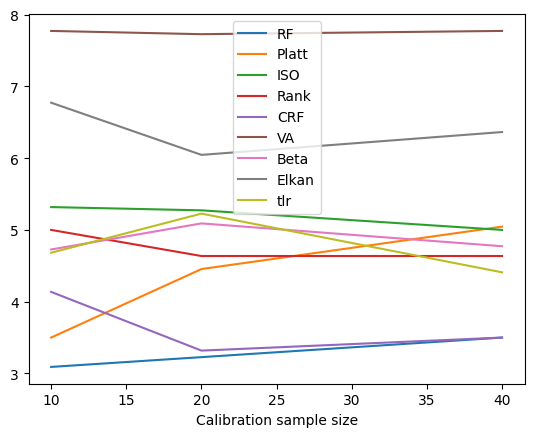

In [6]:
exp_dict["acc"].plot()